In [16]:
from bs4 import BeautifulSoup
import time
from random import randint
import pandas as pd
import re
import sqlite3
import numpy as np
import spacy
from gensim import corpora,models,similarities
from gensim.models import Phrases
from collections import defaultdict
import matplotlib
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
conn = sqlite3.connect('lyrics.db')

In [3]:
nlp = spacy.load('en')

## Clean Lyrics Database

In [4]:
records = pd.read_sql_query("select * from lyrics_abc where valid = 1;",conn)

In [35]:
# allrecords = pd.read_sql_query("select * from lyrics_abc;",conn)
# allrecords['duplicate'] = allrecords['url'].duplicated()

# def update(x):
#     if(x['duplicate']==True)&(x['status']==0):
#         return 1
#     elif x['status'] == 1 : 
#         return 1
#     else : return 0

# allrecords['new_status'] = allrecords.apply(lambda x: update(x),axis=1)
# allrecords['status'] = allrecords['new_status']
# del allrecords['new_status']

# allrecords[allrecords['url']=='http://cyberhymnal.org/htm/b/e/beautxms.htm']
# print('scrapped:',allrecords[allrecords['status']==1]['status'].count())
# print('not scrapped:',allrecords[allrecords['status']==0]['status'].count())
# print('total:',allrecords['status'].count())
# del allrecords['duplicate']

# allrecords.to_sql('lyrics_abc',conn,if_exists='replace')

In [72]:
# def update(x):
#     if x['fullhtml'] is None:
#         return 0
#     elif x['song_name'] == "  Page not found - CyberHymnal" :
#         return 0
#     else :
#         return 1

# records[records['fullhtml'].notnull()]
# records.iloc[7692]['song_name']
# records['valid'] = records.apply(lambda x:update(x),axis=1)
# records.to_sql('lyrics_abc',conn,if_exists='replace')

In [75]:
columns = ['key','title','composer_music','music_year','composer_lyrics','lyrics_year','lyrics']
df = pd.DataFrame(columns=columns)

for reckey,record in records.iterrows():
    soup = BeautifulSoup(record['fullhtml'],"lxml")
    key = reckey
    title = soup.title.get_text()
    #print(title," ",key)
    
    composer = re.findall("Words:(.*) Music:(.*?)\"",record['meta'])
    if len(composer) > 0 :
        music = re.findall("[ ]?(.*?)[,.].*",composer[0][1])
        #music = re.findall("(.*)[,.].*",composer[0][1])
        music_yr = re.findall(".*(\d{4})",composer[0][1])
        composer_music = music[0] if len(music) > 0 else 0
        music_year = music_yr[0] if len(music_yr) > 0 else 0
        #print("Music:",composer_music)
        #print("Year:",music_year)


        words = re.findall("[ ]?(.*?),.*",composer[0][0])
        words_year = re.findall(".*(\d{4})",composer[0][0])   

        composer_lyrics = words[0] if len(words) > 0 else 0
        lyrics_year = words_year[0] if len(words_year) > 0 else 0
        #print("Lyrics:",composer_lyrics)
        #print("Year:",lyrics_year)
    else : 
        composer_lyrics = ""
        lyrics_year = 0 
        composer_music = ""
        music_year = 0 
          
    lyrics = BeautifulSoup(record['lyrics'],"lxml").get_text()
    #print(lyrics)
    
    row = [key,title,composer_music,music_year,composer_lyrics,lyrics_year,lyrics]
    #print(composer)
    #print([composer_music,music_year,composer_lyrics,lyrics_year])
    df.loc[len(df)] = row 
    
    
    #print('--------------------------')
df.to_sql('cleaned_lyrics',conn,if_exists='replace')

## Analyze Database

In [4]:
records = pd.read_sql_query("select * from cleaned_lyrics;",conn)

In [ ]:
## Steps for Git
Git add <file> 
Git commit -m "comments" 
Git push origin master

In [108]:
records.iloc[1,:]

index                                                              1
key                                                                1
title                                            Abide in Me, O Lord
composer_music                                        Templi Carmina
music_year                                                      1853
composer_lyrics                                        Harriet Stowe
lyrics_year                                                     1855
lyrics             \nAbide in me, O Lord, and I in Thee,\r\nFrom ...
Name: 1, dtype: object

In [97]:
# Experiment with Phrases : Need to break up into sentences
# http://www.markhneedham.com/blog/2015/02/12/pythongensim-creating-bigrams-over-how-i-met-your-mother-transcripts/
# phrases = []
# for key,row in records.iterrows():
#     clean_lyrics = row['lyrics'].lower().replace('\nRefrain\n',' ').replace('\r\n',' ').replace('\n',' ')
#     if len(clean_lyrics) > 0 : phrases.append(clean_lyrics)
# #break into sentence
# bigram = Phrases(phrases)
# pre_doc_1 = bigram[phrases]


/home/chenjennhaur/anaconda3/lib/python3.5/site-packages/gensim/models/phrases.py:274: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [5]:
documents = []
documents_entity = []
documents_lemma = []
empty_index = []
doc_key = []
#x = 10
for key,row in records.iterrows():
    clean_lyrics = row['lyrics'].lower().replace('\nrefrain\n',' ').replace('\r\n',' ').replace('\n',' ')
    processed_lyrics = nlp(clean_lyrics)
    token_lyrics = [token.text for token in processed_lyrics if token.is_stop != True and token.is_punct != True and str(token) != ' ']
    lemma_lyrics = [token.lemma_ for token in processed_lyrics if token.is_stop != True and token.is_punct != True and str(token) != ' ']
    ents = list(processed_lyrics.ents) 
    entity_lyrics = []
    for entity in ents:
        ent_temp = entity.label_, ' '.join(t.orth_ for t in entity)
        entity_lyrics.append(ent_temp)
        
    if len(token_lyrics) > 0 :
        documents.append(token_lyrics)
        documents_lemma.append(lemma_lyrics)
        documents_entity.append(entity_lyrics)
        doc_key.append(row['key'])
    else:
        empty_index.append(row['key'])
    #debug
    #x = x - 1 
    #if x == 0 : break



In [127]:
# Search for keywords 
mask = records['lyrics'].str.contains("[Rr]efrain")
itemindex = np.where(mask==True)
print(itemindex)

(array([   6,    9,   10, ..., 6475, 6476, 6486]),)

In [136]:
# Analyze where all the refrains are coming from 
view = 10
print(documents[doc_key.index(view)])
print('--------')
records['lyrics'][view]


['look', 'jesus', 'tree', 'able', 'save', 'dying', 'willing', 'save', 'refrain', 'able', 'save', 'poor', 'sinner', 'lost', 'willing', 'save', 'fearful', 'cost', 'able', 'save', 'come', 'trust', 'pow’r', 'willing', 'save', 'hour', 'o', 'love', 'melt', 'heart', 'able', 'save', 'sin', 'depart', 'willing', 'save', 'refrain', 'let', 'plead', 'vain', 'able', 'save', 'let', 'blood', 'wash', 'stain', 'willing', 'save', 'refrain', 'let', 'enter', 'heart', 'able', 'save', 'wait', 'depart', '’s', 'waiting', 'save', 'refrain']
--------


'\nLook to Jesus on the tree,\r\nHe is able to save you;\r\nDying there for you and me,\r\nHe is willing to save you.\nRefrain\nAble to save a poor sinner lost,\r\nWilling to save at a fearful cost;\r\nAble to save: Come, trust in His pow’r;\r\nWilling to save this very hour.\nO His love will melt your heart,\r\nHe is able to save you;\r\nIf from sin you will depart,\r\nHe is willing to save you.\nRefrain\nDo not let Him plead in vain,\r\nHe is able to save you.\r\nLet His blood wash every stain,\r\nHe is willing to save you.\nRefrain\nLet Him enter now your heart,\r\nHe is able to save you;\r\nIf you wait He will depart,\r\nNow He’s waiting to save you.\nRefrain\n'

In [124]:
print(len(empty_index))
print(empty_index[1:4])
print(doc_key[1:4])

468
[12.0, 14.0, 18.0]
[1.0, 2.0, 3.0]


In [6]:
dictionary = corpora.Dictionary(documents)    
dictionary.save('hymnal.dict')
# print(dictionary)
# for k,v in dictionary.items():
#     print(k," ",v)

In [7]:
corpus = [dictionary.doc2bow(text) for text in documents]
corpora.MmCorpus.serialize('hymnal.mm',corpus)

# print(corpus[0])
# for i in corpus[0]:
#     print(dictionary[i[0]])

## TODO : Show top words across the songs (E.g Love, God)

In [59]:
def showwords(vec):
    for v in vec:
        print(dictionary[v[0]])

In [18]:
#TfIDF
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# LSI
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=300)
corpus_lsi = lsi[corpus_tfidf]
lsi.print_topics(2)

# LDA
# lda = models.LdaModel(corpus, id2word=dictionary, num_topics=100)
# corpus_lda = lda[corpus_tfidf]

[(0,
  '0.273*"thy" + 0.185*"thee" + 0.175*"thou" + 0.136*"jesus" + 0.134*"o" + 0.133*"shall" + 0.120*"god" + 0.120*"come" + 0.118*"lord" + 0.111*"praise"'),
 (1,
  '0.424*"thy" + 0.302*"thou" + -0.257*"jesus" + 0.249*"thee" + -0.194*"hallelujah" + -0.146*"sing" + -0.146*"coming" + 0.135*"thine" + 0.134*"art" + -0.134*"glory"')]

In [54]:
query = "Amazing Grace how sweet the sound that saved a wretch like me i once was lost but now am found"
query_bow = dictionary.doc2bow(query.lower().split())
vec_lsi = lsi[tfidf[query_bow]] # convert the query to LSI space
# print(vec_lsi)

index = similarities.MatrixSimilarity(corpus_lsi) # transform corpus to LSI space and index it
sim = index[vec_lsi]

In [60]:
showwords(query_bow)

lost
grace
found
sound
sweet
like
amazing
saved
wretch


In [55]:
x = 10
for i in enumerate(sim):
    print(i)
    x=x-1
    if x==0 : break

(0, 0.1025758)
(1, 0.0134775)
(2, 0.0041332692)
(3, 0.0094301933)
(4, 0.0014616325)
(5, -0.017952997)
(6, -0.01416873)
(7, 0.012469491)
(8, -0.00057882071)
(9, 0.026483709)


In [56]:
sims = sorted(enumerate(sim),key=lambda x:x[1],reverse=True)
for i in range(10):
    print(sims[i])
    # record_index = doc_key[sims[i][0]]
    # print(records[records['key'] == record_index]['lyrics'])
    print(documents[sims[i][0]])


(4763, 0.61116272)
['saved', 'uttermost', 'lord', '’s', 'jesus', 'savior', 'salvation', 'affords', 'gives', 'spirit', 'witness', 'whispering', 'pardon', 'saving', 'sin', 'saved', 'saved', 'saved', 'uttermost', 'saved', 'saved', 'power', 'divine', 'saved', 'saved', 'saved', 'uttermost', 'jesus', 'savior', 'saved', 'uttermost', 'jesus', 'near', 'keeping', 'safely', 'casteth', 'fear', 'trusting', 'promises', 'blest', 'leaning', 'sweet', 'rest', 'saved', 'uttermost', 'darkness', 'day', 'beautiful', 'visions', 'glory', 'jesus', 'brightness', 'revealed', 'unto', 'saved', 'uttermost', 'cheerfully', 'sing', 'loud', 'halleluiahs', 'jesus', 'king', 'ransomed', 'pardoned', 'redeemed', 'blood', 'cleansed', 'unrighteousness', 'glory', 'god']
(4758, 0.60397732)
['saved', 'saved', 'saved', 'sins', 'forgiv’n', 'christ', '’m', 'way', 'heav’n', 'guilty', 'sinner', 'lost', 'undone', 'child', 'god', 'saved', 'thro’', 'son', 'saved', '’m', 'saved', 'thro’', 'christ', 'saved', '’m', 'saved', 'befall', 'died

In [140]:
frequency = defaultdict(int)
for text in documents:
    for token in text:
        frequency[token] += 1
        
# import pickle

# with open('frequency.txt', 'wb') as fp:
#     pickle.dump(frequency, fp)

ordered = sorted(frequency.items(),key=lambda k:k[1],reverse=True)
ordered[1:20]

[('’s', 7351),
 ('god', 6816),
 ('thee', 6598),
 ('lord', 6472),
 ('o', 5961),
 ('shall', 5637),
 ('love', 5296),
 ('thou', 5047),
 ('jesus', 4750),
 ('let', 3164),
 ('come', 3103),
 ('day', 2933),
 ('life', 2784),
 ('heart', 2764),
 ('glory', 2746),
 ('praise', 2624),
 ('savior', 2469),
 ('light', 2420),
 ('grace', 2335)]

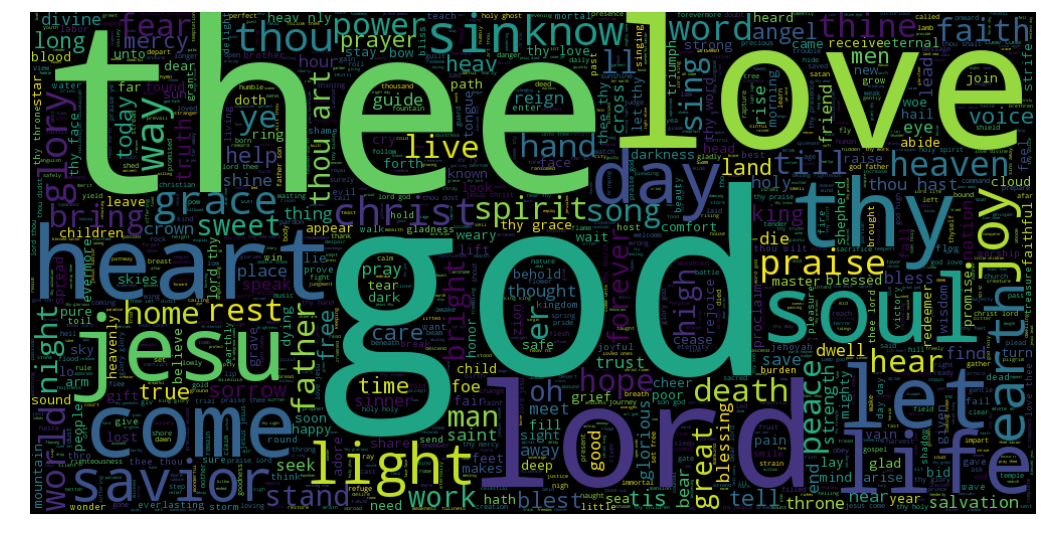

In [139]:
#Non-Root Word

from wordcloud import WordCloud

flat_doc = ' '.join([str(word) for hymn in documents for word in hymn])
hymncloud = WordCloud(width=1000,height=500,max_words=2000).generate(flat_doc)
plt.figure(figsize=(18,10))
plt.imshow(hymncloud)
plt.axis("off")
plt.show()


In [27]:
frequency_lemma = defaultdict(int)
for text in documents_lemma:
    for token in text:
        frequency_lemma[token] += 1
        
# import pickle

# with open('frequency.txt', 'wb') as fp:
#     pickle.dump(frequency, fp)

ordered = sorted(frequency_lemma.items(),key=lambda k:k[1],reverse=True)
ordered[1:20]

[('god', 6847),
 ('thee', 6598),
 ('lord', 6520),
 ('’s', 6519),
 ('love', 6029),
 ('o', 5961),
 ('shall', 5637),
 ('thou', 5047),
 ('come', 4867),
 ('jesus', 4651),
 ('heart', 3887),
 ('day', 3521),
 ('let', 3173),
 ('praise', 3108),
 ('life', 2940),
 ('glory', 2913),
 ('soul', 2911),
 ('light', 2532),
 ('savior', 2469)]

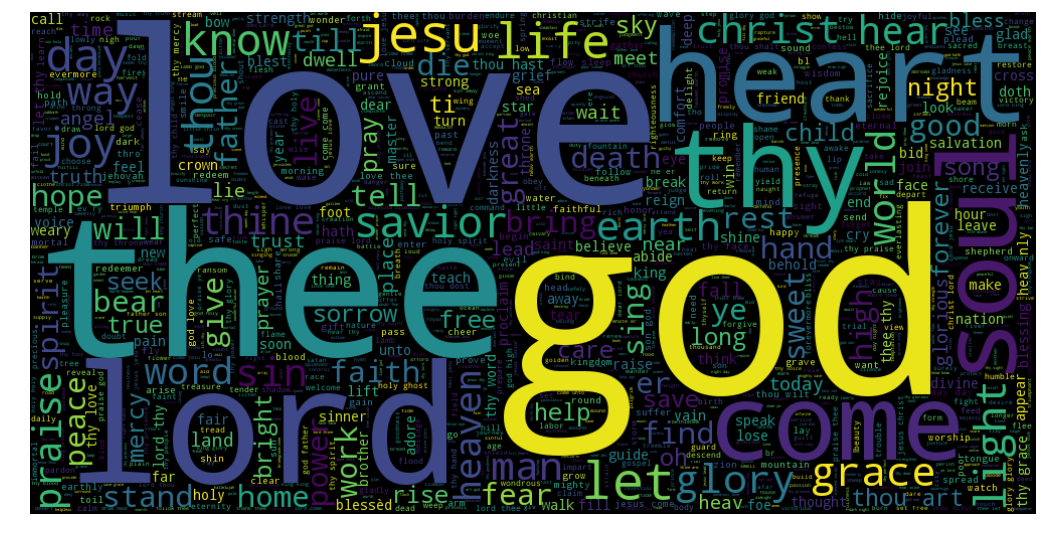

In [26]:
#Lemmatization Word

from wordcloud import WordCloud

flat_lemma_doc = ' '.join([str(word) for hymn in documents_lemma for word in hymn])
hymncloud = WordCloud(width=1000,height=500,max_words=2000).generate(flat_lemma_doc)
plt.figure(figsize=(18,10))
plt.imshow(hymncloud)
plt.axis("off")
plt.show()

In [43]:
entity_type_list = []
for song in documents_entity:
    song_ent_list = []
    for ent_type in song : 
        song_ent_list.append(ent_type[0])
    entity_type_list.append(song_ent_list)

In [47]:
index = 100
print(entity_type_list[index])
print(documents_entity[index])

['CARDINAL', 'DATE']
[('CARDINAL', '’s'), ('DATE', 'today')]


In [57]:
unique_entity = set([w for e in entity_type_list for w in e])
unique_entity

{'CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART'}

In [58]:
test = entity_type_list[0:5]
test

[['GPE'],
 ['TIME', 'CARDINAL', 'TIME', 'CARDINAL'],
 ['GPE'],
 ['DATE'],
 ['DATE']]

In [66]:
data_frame = []
for song in entity_type_list:
    ent_freq = defaultdict(int)
    for ent in song:
        ent_freq[ent] += 1
    data_frame.append(ent_freq)
df_entity = pd.DataFrame(data_frame)

In [67]:
df_entity.fillna(0,inplace=True)
df_entity
## TODO Try to print Histogram

,CARDINAL,DATE,EVENT,FAC,GPE,LAW,LOC,MONEY,NORP,ORDINAL,ORG,PERCENT,PERSON,PRODUCT,QUANTITY,TIME,WORK_OF_ART
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [31]:
# mapping between words and id
print(dictionary.token2id)

{'confounded': 4221, 'chalices': 16764, 'benumb': 11338, 'sepulcher': 8115, 'wrecked': 4059, 'behalf': 10962, 'pacific': 12764, 'endris': 16178, 'drops': 2642, 'sayeth': 11266, 'glorious': 1186, 'nightly': 7999, 'sheepfold': 8329, 'starlit': 10678, 'faithless': 460, 'solely': 5154, 'Shamed': 11452, 'instrument': 13374, 'abides': 4147, 'loosen': 16541, 'harvesting': 6545, 'hastening': 4012, 'blights': 13127, 'Bashan': 17045, 'unwary': 14262, 'wistful': 14573, 'forth': 1430, 'brutes': 11935, 'Suffice': 8188, 'clanging': 8300, 'brazen': 13872, 'wider': 3239, 'wending': 7678, 'quill': 13273, 'undisturbed': 3609, 'Shake': 3836, 'rapture': 693, 'shocks': 11297, 'sickening': 15167, 'o’erpower': 8845, 'Torrents': 13382, 'Spice': 13368, 'cov’ring': 12946, 'snares': 1486, 'Isle': 4349, 'cluster': 12246, 'fathers': 3048, 'Meek': 6725, 'sparkling': 4390, 'wives': 13238, 'Scarce': 1304, 'sing': 430, 'protest': 14756, 'caroling': 4447, 'thoughtfully': 10972, 'valor': 4726, 'besiege': 15125, 'receivè

In [21]:
lyrics = records['lyrics'][0]
print(lyrics)
clean_lyrics = lyrics.replace('\r\n',' ').replace('\n',' ')
print(clean_lyrics)


“Abba, Father!” We approach Thee
In our Savior’s precious Name;
We, Thy children, here assembled,
Now Thy promised blessing claim;
From our sins His blood hath washed us,
’Tis through Him our souls draw nigh,
And Thy Spirit, too, hath taught us,
“Abba, Father,” thus to cry.
Once as prodigals we wandered
In our folly far from Thee,
But Thy grace, o’er sin abounding,
Rescued us from misery;
Thou Thy prodigals hast pardoned,
Kissed us with a Father’s love,
Spread the festive board, and called us,
E’er to dwell with Thee above.
Clothed in garments of salvation,
At Thy table is our place,
We rejoice, and Thou rejoicest,
In the riches of Thy grace;
“It is meet,” we hear Thee saying,
“We should merry and be glad,
I have found My once lost children,
Now they live who once were dead.”
“Abba, Father!” all adore Thee,
All rejoice in Heav’n above,
While in us they learn the wonders
Of Thy wisdom, grace, and love;
Soon before Thy throne assembled,
All Thy children shall proclaim,
“Glory, everlasti

In [22]:
slyrics = nlp(lyrics)
sclyrics = nlp(clean_lyrics)

swords = [token.text for token in slyrics if token.is_stop != True and token.is_punct != True]
scwords = [token.text for token in sclyrics if token.is_stop != True and token.is_punct != True]
# words = [token.text for token in lyrics_1 if token.is_stop != True and token.is_punc != True and token.pos_ == 'NOUN']
print(swords)
print("------------------")
print(scwords)

# for num,sentence in enumerate(lyrics_1.sents):
#     print(num," ",sentence)


['\n', 'Abba', 'Father', 'approach', 'Thee', '\r\n', 'Savior', '’s', 'precious', '\r\n', 'Thy', 'children', 'assembled', '\r\n', 'Thy', 'promised', 'blessing', 'claim', '\r\n', 'sins', 'blood', 'hath', 'washed', '\r\n', '’Tis', 'souls', 'draw', 'nigh', '\r\n', 'Thy', 'Spirit', 'hath', 'taught', '\r\n', 'Abba', 'Father', 'cry', '\n', 'prodigals', 'wandered', '\r\n', 'folly', 'far', 'Thee', '\r\n', 'Thy', 'grace', 'o’er', 'sin', 'abounding', '\r\n', 'Rescued', 'misery', '\r\n', 'Thou', 'Thy', 'prodigals', 'hast', 'pardoned', '\r\n', 'Kissed', 'Father', '’s', 'love', '\r\n', 'Spread', 'festive', 'board', 'called', '\r\n', 'E’er', 'dwell', 'Thee', '\n', 'Clothed', 'garments', 'salvation', '\r\n', 'Thy', 'table', 'place', '\r\n', 'rejoice', 'Thou', 'rejoicest', '\r\n', 'riches', 'Thy', 'grace', '\r\n', 'meet', 'hear', 'Thee', 'saying', '\r\n', 'merry', 'glad', '\r\n', 'found', 'lost', 'children', '\r\n', 'live', 'dead', '\n', 'Abba', 'Father', 'adore', 'Thee', '\r\n', 'rejoice', 'Heav’n', '

In [ ]:
## Clean the Reviews.

In [ ]:
## Perform LSTM 
# https://nicschrading.com/project/Intro-to-NLP-with-spaCy/
# http://blog.sharepointexperience.com/2016/01/nlp-and-sharepoint-part-1/
# https://github.com/JonathanReeve/advanced-text-analysis-workshop-2017/blob/master/advanced-text-analysis.ipynb
# http://nbviewer.jupyter.org/github/skipgram/modern-nlp-in-python/blob/master/executable/Modern_NLP_in_Python.ipynb